# Plotting 

## Getting ready

We import the python modules we need and prepare for making some nice figures.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns 
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import sys

In [2]:
# spesify general variables
datapath = '../data/'
figpath = "path/to/figures/"

circ_filepath = datapath+'circulations/'
est_filepath = datapath+"estimates/"

# Set to True to save figures. Figures are saved in the folder spesifyed by figpath
savefigs = False

In [3]:
# set up fonts for plots
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [4]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """
    Set figure dimensions to avoid scaling in LaTeX.
    
    Source : https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    elif width == 'one_column':
        width_pt = 229.5
    elif width == 'two_columns':
        width_pt = 469.0
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

## Map with streamlines

We are first creating a map with the following information:
- Bathymetry of ROMS-A4 model simulations
- Locations of moorings
- Streamlines of depth-averaged velocity in ROMS-A4
- Filtered dept contours (100 km filter size)
- Unfiltered depth contours

The velocity data is taken from the file [A4mean.nc ](data/full_domain/A4mean.nc), which contains time mean model fields.
Contours have been created using the script [create_contours.py](create_contours.py). 
Contours can also be made interactively with the notebook [create_contours.ipynb](create_contours.ipynb).

### Code

In [5]:
%%capture  

# Mooring locations in model coordinates
moorings = {
    '1' : (1229, 987),
    '2' : (1192, 919),
    '3' : (1149, 965),
    '4' : (1174, 1040),
    '5' : (920, 457),
    '6' : (922, 460),
    '7' : (923, 462),
    '8' : (900, 467),
    '9' : (903, 471),
    '10' : (903, 471),
    '11' : (661, 282),
    '12' : (657, 250),
    '13' : (651, 252),
    '14': (657, 251)
    }

# Read time mean velocity fields for streamlines
filename = "A4mean.nc"
filepath = datapath+"full_domain/"
ds = xr.open_dataset(filepath+filename).squeeze().isel(eta_rho=slice(1,-1), xi_rho=slice(1,-1))

# shift velocities to cell center
ubar = 0.5*(ds.ubar.values[1:-1,1:]+ds.ubar.values[1:-1,:-1])
vbar = 0.5*(ds.vbar.values[1:,1:-1]+ds.vbar.values[:-1,1:-1])

# select bathymetry and land mask
bath = ds.h
mask = ds.mask_rho

# apply land mask
bath = bath.where(mask ==1 )

# Find contour files for plotting contours
contour_filepath = datapath+'contours/'

cfiles = glob.glob(contour_filepath+f"*_100000.nc")
cfiles_nofilter = glob.glob(contour_filepath+f"*_0.nc")

# apperance
obscolor = '#fa8312ff'    # color of mooring locations
higlight = '2750'           # which contour to higlight
higlightcolor = "red"       # color to use for higlighted contour
width = "two_columns"       # figure will span two columns

# setting up figure
fig_map, ax = plt.subplots(constrained_layout=True, figsize=set_size(width,subplots=(1, 1), fraction=2))
ax.set_aspect('equal')

### plot bathymetry

ax.imshow(mask[::-1,::-1].T, cmap='gist_gray', vmin = -6)
ax.imshow(bath[::-1,::-1].T, 
          #cmap=cmocean.cm.deep
          cmap = 'Blues'
         )

### plot filtered contours

for cfile in cfiles:
    depth = cfile.split("_")[-2]
    if depth == higlight:
        color = higlightcolor
    else:
        color = 'black'
    
    
    dsc = xr.open_dataset(cfile)
    indx = dsc.index_x
    jndx = dsc.index_y
    
    ax.plot(1201-jndx, 1601-indx, linewidth=1, 
            color=color
           )


### plot location of moorings

for nr, coord in moorings.items():
    ax.plot(1201-coord[1], 1601-coord[0], marker = 'x', color = obscolor, zorder = 7)


### plot streamlines in main panel

x = np.arange(1200)
y = np.arange(1600)

X, Y = np.meshgrid(x, y)


ax.streamplot(X, Y,  -vbar[::-1,::-1].T,-ubar[::-1,::-1].T, color="gray",
             density = 5,
              linewidth = 0.5,
              arrowsize = 1,
              #broken_streamlines = False,
              zorder=4,
             )


### adjust appearance of main panel

# turn of ticks and labels
ax.tick_params(
    axis='both',         
    which='both',      
    bottom=False,      
    top=False,       
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False,
) 

# turn off the spines
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')


### insert small map in upper right corner for basin names

ax_names = ax.inset_axes(bounds=[0.75, 0.75, 0.25, 0.25])
ax_names.imshow(mask[::-1,::-1].T, cmap='gist_gray', vmin = -6)
ax_names.imshow(bath[::-1,::-1].T, 
          #cmap=cmocean.cm.deep
          cmap = 'gist_yarg',
          vmax = 20e3
         )

ax_names.tick_params(
    axis='both',         
    which='both',      
    bottom=False,      
    top=False,       
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False,
) 

# turn off the spine/ticks
ax_names.spines['right'].set_color('none')
ax_names.spines['left'].set_color('none')
ax_names.spines['top'].set_color('none')
ax_names.spines['bottom'].set_color('none')


# Set frame color to grey
for spine in ax_names.spines.values():
    spine.set_edgecolor('white')


### insert in lower left corner for unfiltered contours

# zoom values
x0 = 180
y0 = 365
dx = int(480*0.6)
dy = int(640*0.6)

# prepare bathymetry data for insert
bath_in = bath[x0:x0+dx, y0:y0+dy]
mask_in = mask[x0:x0+dx, y0:y0+dy]

# create axis and plot bathymetry in insert
ax_in = ax.inset_axes(bounds=[0.02, 0.015, 0.4, 0.4])
ax_in.imshow(mask_in[::-1,::-1].T, cmap='gist_gray', vmin = -6)
ax_in.imshow(bath_in[::-1,::-1].T, 
          #cmap=cmocean.cm.deep
          cmap = 'Blues'
         )

# prepare velocity data for insert
x_in = np.arange(dx)
y_in = np.arange(dy)

X_in , Y_in = np.meshgrid(x_in, y_in)

U_in = -vbar[x0:x0+dx, y0:y0+dy]
V_in = -ubar[x0:x0+dx, y0:y0+dy]

# plot streamlines in insert
ax_in.streamplot(X_in, Y_in,  U_in[::-1,::-1].T, V_in[::-1,::-1].T, color="gray",
             density = 1,
              linewidth = 0.8,
              arrowsize = 1,
              #broken_streamlines = False,
              zorder=4,
             )

# plot filtered and unfiltered contours for the insert
for cfile in cfiles:
    # skip contours other than norwegian 
    if cfile.split("/")[-1].split("_")[0] != "norwegian":
        continue
    depth = cfile.split("_")[-2]
    if depth == higlight:
        color = higlightcolor
    else:
        color = 'black'
    
    # plot raw contour
    dsc_nf = xr.open_dataset(cfile[:-9]+"0.nc")
    indx_nf = dsc_nf.index_x
    jndx_nf = dsc_nf.index_y
    
    ax_in.plot(dx+x0-jndx_nf, dy+y0-indx_nf, linewidth=1, 
            color="orange"
           )
    
    # plot filtered contour
    dsc = xr.open_dataset(cfile)
    indx = dsc.index_x
    jndx = dsc.index_y
    
    ax_in.plot(dx+x0-jndx, dy+y0-indx, linewidth=1, 
            color=color
           )

### adjust appearance of insert

# Set frame color to grey
for spine in ax_in.spines.values():
    spine.set_edgecolor("White")


ax_in.tick_params(
    axis='both',         
    which='both',      
    bottom=False,      
    top=False,       
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False,
) 


### prepare for saving

ax.set_rasterization_zorder(0)
ax_in.set_rasterization_zorder(0)

### Figure

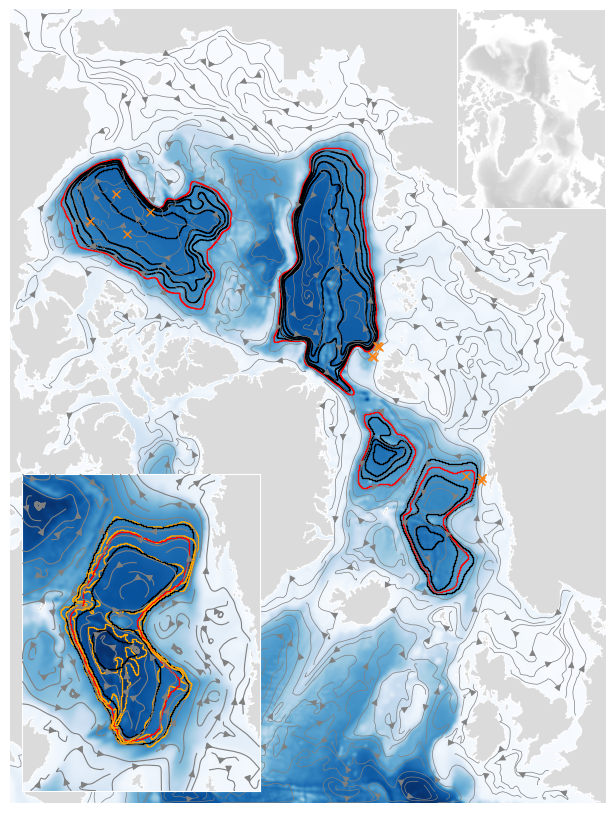

In [6]:
if savefigs:
    fig_map.savefig(figpath+"map.pdf")
fig_map

## Hovmoller diagrams of along-contour velocities

We are now making plots which show how the velocity tangential to a contour vary both in time and and space. 

Theory predicts that the integrated velocity evolves like the integrated and low-pass filtered surface stress over time. Also, the local steepnes is expected to influence the strength of the local velocity.  

We therefore include subplots of the local steepnes, and the integrated, low-pass filtered surface stress.


We will make one figure for the Norwegian Basin, and one for the Canada Basin.

### Code

In [7]:
%%capture  

# we will use a Hanning filter to low-pass filter the integrated surface stress
def hanning_filter(da, window_length=20):
    """
    Apply a Hanning window filter to the input DataArray.

    Parameters:
    da (xr.DataArray): Input data array to be filtered.
    window_length (int): Length of the Hanning window. Default is 20.

    Returns:
    xr.DataArray: The filtered data array.
    """
    # Create a Hanning window of the specified length
    hanning = np.hanning(window_length)
    
    # Normalize the Hanning window and convert it to an xarray DataArray
    window = xr.DataArray(hanning / np.sum(hanning), dims=['window'])
    
    # Apply a rolling window operation to the input DataArray
    rolling = da.rolling(ocean_time=window_length, center=True)
    
    # Construct the rolling window and apply the Hanning filter
    filtered = rolling.construct(ocean_time='window').dot(window)
    
    return filtered

# We wil make two plots with the same set-up, so we make a plotting function
def plot_hovmoller(contour, bath, H, R, width='two_columns'):
    """
    Plot a Hovmöller diagram of along-contour velocity, filtered surface stress,
    slope, and map of bathymetry based on the specified contour.

    Parameters:
    contour (str): Name of the contour to be analyzed (e.g., 'norwegian', 'canadian').
    bath (xr.DataArray): Bathymetry data array.
    H (float): Characteristic depth.
    R (float): Friction parameter.
    width (str): Width of the plot. Default is 'two_columns'.

    Returns:
    matplotlib.figure.Figure: The resulting figure with subplots.
    """
    # Open the dataset with u and v variables interpolated to the contour
    filename = f"U_at_{contour}_2750_100000_interpolate.nc"
    filepath = datapath + "along_contour/"
    ds = xr.open_dataset(filepath + filename)

    xi_rho = ds.xi_rho
    eta_rho = ds.eta_rho
    U = ds.Ubar

    # Calculate mean along-slope surface stress
    tau = ds.taux
    tau_mean = tau.mean(dim="point")

    # Filter surface stress using Hanning window
    window = H / R / (60 * 60 * 24)
    window = int(window)
    tau_filtered = hanning_filter(tau_mean, window_length=window)
    print(f"Smoothing window: {window} days")

    # Interpolate bathymetry to the contour
    bath_contour = bath.interp(xi_rho=xi_rho, eta_rho=eta_rho)

    # Calculate cumulative horizontal distance between gridpoints
    dxx = ds.distance
    xx = np.cumsum(dxx)

    # Calculate the highest absolute value of U for setting plot limits
    Umax = float(np.max(np.abs(U)).values)

    # Create figure with constrained layout
    fig = plt.figure(constrained_layout=True, figsize=(set_size(width)[0], set_size(width)[0]))

    # Define subplot mosaic layout
    axd = fig.subplot_mosaic(
        [
            ['U', 'U', "U", "U", 'tau'],
            ['U', 'U', "U", "U", 'tau'],
            ['U', 'U', "U", "U", 'tau'],
            ['U', 'U', "U", "U", 'tau'],
            ['slope', 'slope', 'slope', 'slope', 'map']
        ]
    )

    # Convert ocean_time to numerical format
    ocean_time_num = mdates.date2num(ds.ocean_time)
    day = np.arange(len(ds.ocean_time))

    # Plot along-slope velocity
    cm = axd["U"].imshow(U * 1e2, vmin=-Umax * 1e2, vmax=Umax * 1e2, cmap=cmocean.cm.balance, aspect='auto', extent=[0, xx[-1], ocean_time_num[-1], ocean_time_num[0]])

    # Add colorbar for velocity
    cb = fig.colorbar(cm, ax=axd["U"], orientation='horizontal', label='Along-contour velocity [cms$^{-1}$]', 
                      location="top", pad=-0.07, aspect=40)
    cb.outline.set_edgecolor('none')

    # Customize velocity plot appearance
    axd['U'].set_ylabel('Time')
    axd['U'].tick_params(labelbottom=False)
    axd["U"].invert_yaxis()
    axd["U"].spines['right'].set_color('none')
    axd["U"].spines['left'].set_color('none')
    axd["U"].spines['top'].set_color('none')
    axd["U"].spines['bottom'].set_color('none')
    axd["U"].xaxis.tick_bottom()
    axd["U"].yaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axd["U"].yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axd['U'].grid(which='major', axis='y', linestyle='-', color='lightgray')

    # Plot filtered surface stress
    axd["tau"].plot(tau_filtered, ocean_time_num, color="black")
    axd["tau"].tick_params(labelleft=False, labelbottom=False, bottom=False)
    axd["tau"].yaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axd["tau"].yaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
    axd["tau"].spines['right'].set_color('none')
    axd["tau"].spines['left'].set_color('lightgray')
    axd["tau"].spines['left'].set_position('zero')
    axd["tau"].spines['top'].set_color('lightgray')
    axd["tau"].spines['bottom'].set_color('none')
    axd["tau"].yaxis.tick_left()

    # Workaround for customizing surface stress ticks to match the velocity plot
    axd["tau_twin"] = axd["tau"].twiny()
    axd["tau_twin"].plot(tau_filtered, ocean_time_num, color="black")
    axd["tau_twin"].tick_params(labelleft=False)
    axd["tau_twin"].set_xlabel('Filtered surface \nstress [Nm$^{-1}$]')
    axd["tau_twin"].spines['right'].set_color('none')
    axd["tau_twin"].spines['left'].set_color('lightgray')
    axd["tau_twin"].spines['left'].set_position('zero')
    axd["tau_twin"].spines['top'].set_color('lightgray')
    axd["tau_twin"].spines['bottom'].set_color('none')

    # Plot slope.
    cmap = cmocean.cm.phase
    t = np.linspace(0, 1, len(xx))
    dxx = np.mean(xx[1:] - xx[:-1])
    for i in range(len(xx) - 1):
        axd['slope'].plot((xx[i], xx[i + 1]), bath_contour.slope[i:i + 2], color=cmap(t[i]))
    axd['slope'].set_ylabel('Slope')
    axd['slope'].set_xlabel('Contour position [km]')
    axd["slope"].spines['right'].set_color('none')
    axd["slope"].spines['left'].set_color('lightgray')
    axd["slope"].spines['top'].set_color('none')
    axd["slope"].spines['bottom'].set_color('lightgray')
    axd["slope"].spines['bottom'].set_position('zero')

    # Plot map with bathymetry
    axm = axd["map"]
    H = bath.H.values
    mask = ~np.isnan(H)
    axm.imshow(mask[::-1, ::-1].T, cmap='gist_gray', vmin=-4)
    axm.imshow(H.T[::-1, ::-1], cmap="Blues")

    # Plot contour on map
    axm.scatter(H.shape[0] - eta_rho.values, H.shape[1] - xi_rho.values, c=np.arange(len(xx)), s=1, cmap=cmocean.cm.phase)

    # Customize map appearance based on contour
    if contour == "norwegian":
        axm.set_xlim(np.min(H.shape[0] - eta_rho.values) - 110, np.max(H.shape[0] - eta_rho.values) + 200)
        axm.set_ylim(np.max(H.shape[1] - xi_rho.values) + 110, np.min(H.shape[1] - xi_rho.values) - 110)
    elif contour == "canadian":
        axm.set_xlim(np.min(H.shape[0] - eta_rho.values) - 110, np.max(H.shape[0] - eta_rho.values) + 110)
        axm.set_ylim(np.max(H.shape[1] - xi_rho.values) + 110, np.min(H.shape[1] - xi_rho.values) - 110)
    axm.set_aspect('equal')
    axm.tick_params(left=False, labelleft=False, top=False, labeltop=False,
                    right=False, labelright=False, bottom=False, labelbottom=False)
    axm.spines['right'].set_color('none')
    axm.spines['left'].set_color('none')
    axm.spines['top'].set_color('none')
    axm.spines['bottom'].set_color('none')

    # Set up shared axes
    axd["U"].sharey(axd["tau"])
    axd["U"].sharex(axd["slope"])
    
    return fig

# read in bathymetric variables used for slope and map
filepath = datapath+"full_domain/"
bath = xr.open_dataset(filepath+'A4_bathymetry_gradient.nc')

dHabs = np.sqrt(bath.dHdx**2+bath.dHdy**2)
bath['slope'] = dHabs
bath['tx'] = bath.dHdy/dHabs
bath['ty'] = -bath.dHdx/dHabs


# parameters settign the low-pass filter. Filter size is H/R
H = 2750
R = 5e-4


fig_hm_nor = plot_hovmoller("norwegian", bath, H, R);
fig_hm_can = plot_hovmoller("canadian", bath, H, R);

### Figures

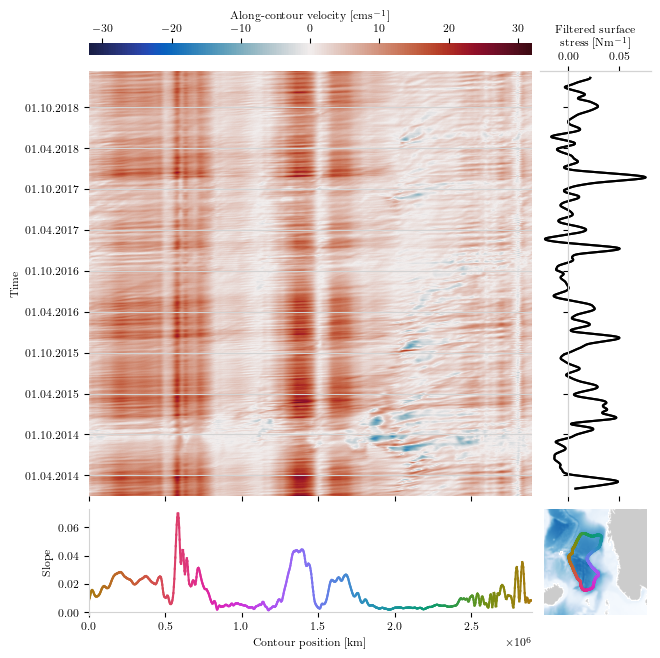

In [8]:
# Norwegian Basin
if savefigs:
    fig_hm_nor.savefig(figpath+"hovmoller_NB.pdf")
fig_hm_nor

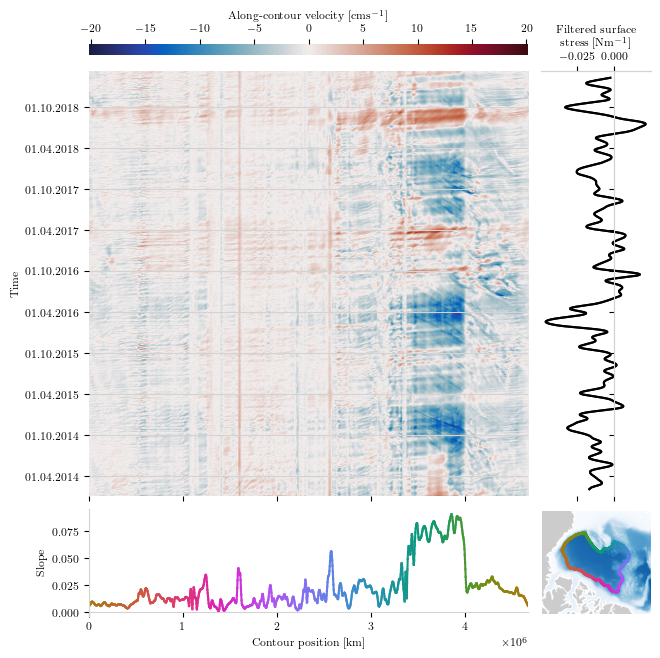

In [9]:
# Canada Basin
if savefigs:
    fig_hm_can.savefig(figpath+"hovmoller_CB.pdf")
fig_hm_can

## Circulation of $\overline{\mathbf{u}}$ and $\mathbf{u}_b$ : time series
It's time for the focus of this study: the time variable circulation around depth contours. 
We will plot both the circulation of the depth averaged and the bottom circulation in ROMS-A4.

Circulations for a selection of contours in ROMS-A4 can be found in the directory **data/circulations**. We will plot circulation around the 2750 m depth contour, smoothed with a low-pass filter of 100 km.

Circulation around contours in ROMS-A4 can be calculated by first creating contours using [create_contours.py](create_contours.py)/[create_contours.ipynb](create_contours.ipynb), and then extracting the circulations by running the script [calculate_circulation.py](calculate_circulation.py). 
The second step requires access to the ROMS-A4 files.  


### Code

In [10]:
%%capture

width = "two_columns"

depth = "2750"
filterscale = 100000

color_depth = '#b8d5edff'
color_bottom = '#0b315bff'
color_analytical = '#fa8312ff'
color_diff = 'lightgray'

titles = dict(
    norwegian = 'Norwegian Basin',
    greenland = 'Greenland Basin',
    eurasian = 'Eurasian Basin',
    canadian = 'Canada Basin'
    )

# Files containing the circulation
cfiles = glob.glob(circ_filepath+f"*_{depth}_{filterscale}_circ.nc")


# Set up figure 
fig_ts_sim = plt.figure(constrained_layout=True, figsize=set_size(width,subplots=(2, 1), fraction = 0.9))

axd = fig_ts_sim.subplot_mosaic(
        [
            ['canadian'],
            ['eurasian'],
            ['greenland'],
            ['norwegian']
        ],
    )

for key, ax in axd.items():
    ax.axis('off')

for cfile in cfiles:
    basin = cfile.split("/")[-1].split("_")[0]
    ax = axd[basin]
    ax.axis('on')

    data = xr.open_dataset(cfile)

    model = data.circ_u*1e2
    modelbottom = data.circ_ub*1e2

    diff = model - modelbottom 

    #corr, _ = pearsonr(model, modelbottom)
    corr = np.corrcoef(model, modelbottom)[0,1]


    ax.plot(model.time, model.values, 
            color=color_depth, 
            label='Depth-averaged circulation', 
            zorder=19)
    ax.plot(model.time, modelbottom.values, 
            color=color_bottom, 
            label = 'Bottom circulation',
            zorder=20)

    ax.plot(model.time, diff.values, color=color_diff, 
            label='Difference', 
            zorder=18)    


    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position('zero')

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()

    # set color of ticks and axes
    #ax.tick_params(colors='lightgray', which='major')
    ax.spines['left'].set_color('lightgray')
    ax.spines['bottom'].set_color('lightgray')

    if basin != 'norwegian':
        ax.set(xticklabels=[])

    # add name of basin
    ax.text(0.02, 1.15, titles[basin], horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes)


    # add correlation
    ax.text(0.98, 1.15, f'correlation = {corr:.2f}', horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes)

axd['canadian'].legend(loc='upper center', 
                    bbox_to_anchor=(0.5, 1.5),
                    ncol=2, 
                    frameon=False,
                )

# adjust ticks spacing for aestethic 
for key, ax in axd.items():
    if key not in ["canadian"]:
        tick_spacing = 2
    else:
        tick_spacing = 2
        
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#fig.suptitle(depth+' m')
fig_ts_sim.supxlabel('Time [year]')
fig_ts_sim.supylabel('Normalized circualtion [cms$^{-1}$]')

### Figure

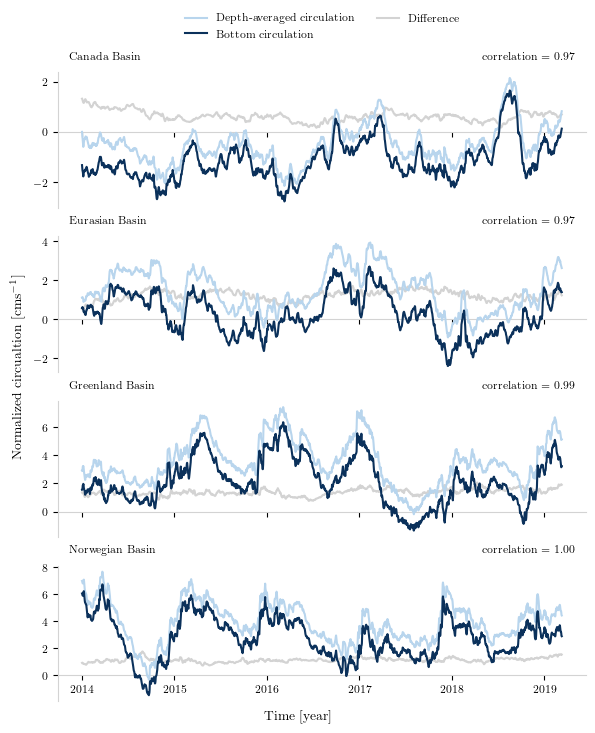

In [11]:
if savefigs:
    fig_ts_sim.savefig(figpath+"timeseries_circulation.pdf")
fig_ts_sim

## Circulation of $\overline{\mathbf{u}}$ and $\mathbf{u}_b$ : 2D histograms 
Time series of the circulation of $\overline{\mathbf{u}}$ and $\mathbf{u}_b$ are very similar, and seem to be separated by an approximatley constant offesett. To futher investigate this, we plot 2D histograms. A 2D histogram is similar to a scatterplot, but shows the data density better. 

Two similar time series, only separated by a constant offest, should form a line parallel to the 1-1 line in such a plot. 

### Code

In [12]:
%%capture

width = 'two_columns'

depth = "2750"

# Titles of individual sub plots
titles = dict(
    norwegian = 'Norwegian Basin',
    greenland = 'Greenland Basin',
    eurasian = 'Eurasian Basin',
    canadian = 'Canada Basin'
    )

# Find circulation files
cfiles = glob.glob(circ_filepath+f"*_{depth}_100000_circ.nc")

fig_hist_sim = plt.figure(constrained_layout=True, figsize=(set_size(width)[1],set_size(width)[1]))
    
# each subplot corresponding to a basin
axd = fig_hist_sim.subplot_mosaic(
        [
            ['canadian', 'eurasian'],
            ['greenland', 'norwegian']
        ],
        # sharex=True,
        # sharey=True
    )

# Loop over circulation files
for cfile in cfiles:
    basin = cfile.split("/")[-1].split("_")[0]
    ax = axd[basin]
    
    data = xr.open_dataset(cfile)

    # extract data and convert to cm s-1
    model = data.circ_u * 1e2
    modelbottom = data.circ_ub * 1e2
    
    # Determine the minimum and maximum values from both datasets for consistent plotting range
    mmin = np.min([np.min(model.values), np.min(modelbottom.values)])
    mmax = np.max([np.max(model.values), np.max(modelbottom.values)])
    
    # Calculate the correlation between the two datasets
    corr = np.corrcoef(model, modelbottom)[0,1]
    
    # plot 1-1 line
    ax.plot([mmin, mmax], [mmin, mmax], ls='--', color="black", lw=1)
    
    # plot 2d histogram
    h = ax.hist2d(x=model.values, y=modelbottom.values, bins=50, cmap="magma_r", cmin=1, vmin=1, vmax=75)

    # Customize the subplot appearance
    # Turn off the right and top spines
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    # Set the position of the bottom and left spines to intersect at zero
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')

    # Set the color of the remaining spines and the ticks
    ax.spines['left'].set_color('lightgray')
    ax.spines['bottom'].set_color('lightgray')
    ax.xaxis.tick_bottom()


    ax.set_aspect('equal')
    
    # Determine tick intervals based on the range of data
    if mmax - mmin > 5:
        step = 2
    else:
        step = 1
        
    # Adjust ticks if step size is 2 and the minimum value is odd
    if step == 2 and round(mmin) % 2 != 0:
        shift = 1
    else:
        shift = 0
    
    # Create ticks, removing zero 
    ticks = np.arange(round(mmin+shift), round(mmax+1), step)
    ticks = np.delete(ticks, np.where(ticks == 0))
    
    # Set the ticks on the x and y axes
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    
    # Add the name of the basin as the title of the subplot
    ax.text(0.02, 1.15, titles[basin], horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes)

    # Optionally, add the correlation value as text on the plot
    # ax.text(0.98, 1.15, f'correlation = {corr:.2f}', horizontalalignment='right',
    #      verticalalignment='top', transform=ax.transAxes)
    
# Add common labels for all subplots
fig_hist_sim.supxlabel('Normalized depth averaged circulation [cms$^{-1}$]')
fig_hist_sim.supylabel('Normalized bottom circulation [cms$^{-1}$]')

### Figure

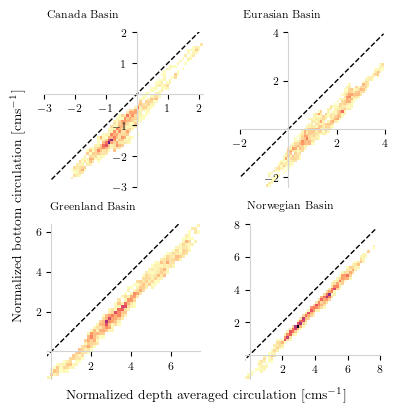

In [13]:
 if savefigs:
    fig_hist_sim.savefig(figpath+"simulations_scatter.pdf")
 fig_hist_sim

## Vertical structure along two contours
We want to look closer into the vertical structure of the circulation. For this, we create a colorplot with time on the x-axis, mean depth of sigma-layers on the y-axis, and color indicating the circulaiton. We create one plot for the 2750 m depth contour in the Norwegian basin, and one for the Canada Basin.

### Code

In [14]:
%%capture

def plot_structure(U, z, fig, ax, axp):
    """
    Plot the vertical structure of circulation and its mean profile.

    Parameters:
    U (xarray.DataArray): The 2D array of circulation data over time and depth.
    z (xarray.DataArray or numpy.ndarray): The vertical coordinates (depths).
    fig (matplotlib.figure.Figure): The figure object to which the plots are added.
    ax (matplotlib.axes.Axes): The primary axis for the pcolormesh plot.
    axp (matplotlib.axes.Axes): The axis for plotting the mean profile with standard deviation.

    Returns:
    None
    """
    
    # Extract time values from the U dataset
    x = U.ocean_time.values
    
    # Calculate the maximum absolute value of U for color scaling
    Umax = np.max(np.abs(U.values.flatten()))

    # Create a pcolormesh plot of the circulation data, normalized and with color mapping
    cm = ax.pcolormesh(x, z / 1e3, U.T * 1e2, vmin=-Umax * 1e2, vmax=Umax * 1e2, 
                       cmap=cmocean.cm.balance, shading='nearest')
    cm.set_rasterized(True)

    # Set y-axis properties and label
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel("Depth [km]")

    # Add a colorbar for the pcolormesh plot
    cb = fig.colorbar(cm, label="Normalized\ncirculation [cm/s]", ax=ax, 
                      location="left", pad=0, aspect=40, shrink=0.9)
    cb.outline.set_edgecolor('none')

    # Remove the plot spines for a cleaner look
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    # Plot the mean profile of U with its standard deviation
    profile = U.mean("ocean_time") * 1e2
    std = (U * 1e2).std("ocean_time")
    axp.plot(profile, z / 1e3, color="black", zorder=20)
    axp.fill_betweenx(z / 1e3, profile - std, profile + std, color="gray", alpha=0.3, zorder=18)

    # Customize the profile axis appearance
    axp.spines['left'].set_position('zero')
    axp.spines['top'].set_color('none')
    axp.spines['right'].set_color('none')
    axp.xaxis.tick_bottom()
    
    axp.spines['left'].set_color('lightgray')
    axp.spines['bottom'].set_color('lightgray')

    
def calculate_zlevels(ds, dss):
    """
    Calculate the average z-levels at rho points.

    Parameters:
    ds (xarray.Dataset): The dataset containing the contour.
    dss (xarray.Dataset): The dataset containing the bathymetric and vertical coordinate information.

    Returns:
    xarray.DataArray: The mean interpolated z-levels.
    """
    
    # Calculate the depth at rho points
    Zo_rho = (dss.hc * dss.s_rho + dss.Cs_r * dss.h) / (dss.hc + dss.h)
    z_rho = Zo_rho * (dss.zeta + dss.h) + dss.zeta
    
    # Apply mask to z_rho and transpose to standard dimensions
    z_rho = z_rho.where(dss.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')
    
    # Interpolate z_rho to the contour
    zs = z_rho.interp(eta_rho=ds.eta_rho, xi_rho=ds.xi_rho)
    
    # Compute the mean z-level along the contour 
    z = zs.mean("point")
    return z

# Load mean dataset with bathymetric information and remove any singleton dimensions
dsmean = xr.open_dataset(datapath+"full_domain/A4mean.nc").squeeze()

# Load datasets with depth-dependent circulaiton
dsN = xr.open_dataset(datapath+"along_contour/U_at_norwegian_2750_100000_interpolate.nc")
dsC = xr.open_dataset(datapath+"along_contour/U_at_canadian_2750_100000_interpolate.nc")

# Calculate mean z-levels for sigma-layers
zN = calculate_zlevels(dsN, dsmean)
zC = calculate_zlevels(dsC, dsmean)


UN = dsN.U
UC = dsC.U


# Set up figure
width = "two_columns"

fig_structure = plt.figure(
    layout="constrained", 
    #layout='tight',
    figsize=set_size(width)
    )
axd = fig_structure.subplot_mosaic(

    [
        ["hmC", "hmC", "hmC",   "pC"],
        ["hmN", "hmN", "hmN",  "pN"],
    ],
    sharey = True
)


# Share x-axis between Canadian and Norwegian heatmaps and their profiles
axd['hmN'].sharex(axd['hmC'])
axd['pN'].sharex(axd['pC'])


# Assign individual axes for easier reference
axC = axd["hmC"]
axN = axd["hmN"]

axpC = axd["pC"]
axpN = axd["pN"]

# Plot
plot_structure(UC, zC, fig_structure, axC, axpC)
plot_structure(UN, zN, fig_structure, axN, axpN)

# Customize the plot appearance
axC.tick_params(labelbottom=False)
axpC.tick_params(labelbottom=False)

axpN.set_xlabel("Time-mean normalized\ncirculation [cms$^{-1}$]")
axN.set_xlabel("Time [year]")

### Figure

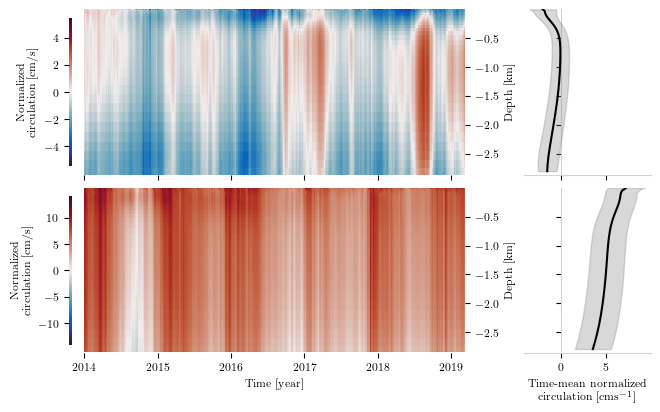

In [15]:
if savefigs:
    fig_structure.savefig(figpath+"structure.pdf")
fig_structure

## Linear model estimates : time series
Now it's time to compare ROMS-A4 with estimates given by the linear model:

$$
\oint_{C(H)} {\mathbf{u}}_b \cdot \hat{\mathbf{t}}\,dl = \exp\left(- \frac{R}{H}t\right) \oint_{C(H)} \mathbf{u}_b^0 \cdot \hat{\mathbf{t}}\,dl + \int_{t_0}^t \exp\left[-   \frac{R}{H}\left(t-t'\right)\right] \frac{1}{H}\oint_{C(H)}\mathbf{\tau}_s \cdot \hat{\mathbf{t}}\,dl \, dt'.
$$

Estimates are calculated by running the script [linear_model.py](linear_model.py) or the notebook [linear_model.ipynb](linear_model.ipynb). Estimates are stored in the direvtory **data/estimates**. Below, we plot time series of $\oint_{C(H)} {\mathbf{u}}_b \cdot \hat{\mathbf{t}}\,dl$ taken directly from ROMS-A4 together with linear model estimates.

### Code

In [16]:
%%capture

# Set the width of the figure layout
width = "two_columns"

# Define colors for different plot elements
color_depth = '#b8d5edff'
color_bottom = '#0b315bff'
color_analytical = '#fa8312ff'
color_diff = 'lightgray'

# Define the titles for different basins
titles = dict(
    norwegian='Norwegian Basin',
    greenland='Greenland Basin',
    eurasian='Eurasian Basin',
    canadian='Canada Basin'
)

# Define the depth level and filter scale for the analysis
depth = 2750
filter_scale = 100000

# Filepath to estimates
est_filepath = datapath + 'estimates/'

# Find all files corresponding to the specified depth and filter scale
cfiles = glob.glob(est_filepath + f"*_{depth}_{filter_scale}_estimates.nc")

# Initialize the figure 
fig_ts_est = plt.figure(constrained_layout=True, figsize=set_size(width, subplots=(2, 1), fraction=0.9))
axd = fig_ts_est.subplot_mosaic(
    [
        ['canadian'],
        ['eurasian'],
        ['greenland'],
        ['norwegian']
    ],
)

# Turn off axis visibility for all subplots initially
for key, ax in axd.items():
    ax.axis('off')

# Loop through each file and plot the data
for cfile in cfiles:
    # Extract the basin name from the filename
    basin = cfile.split("/")[-1].split("_")[0]
    
    # Get the corresponding axis for the basin
    ax = axd[basin]
    ax.axis('on')

    # Open the dataset from the NetCDF file
    data = xr.open_dataset(cfile)

    # Extract model data and convert to cm s-1
    model = data.circ_u * 1e2
    modelbottom = data.circ_ub * 1e2

    # Find the R value with the maximum correlation coefficient
    corr = data.r.max().values
    R = data.r.idxmax().values

    # Select the dataset for the optimal R value
    analytical = data.sel(R=R).estimates * 1e2

    # Plot the simulated data
    ax.plot(modelbottom.time, modelbottom.values,
            color=color_bottom,
            label="Simulations",
            zorder=20
            )

    # Plot the idealized model estimates
    ax.plot(analytical.time, analytical.values,
            color=color_analytical,
            label='Idealized model estimates',
            zorder=22
            )

    # Customize the axis appearance
    ax.spines['right'].set_color('none')  # Remove the right spine
    ax.yaxis.tick_left()  # Keep the left ticks
    ax.spines['bottom'].set_position('zero')  # Set the bottom spine position
    ax.spines['top'].set_color('none')  # Remove the top spine
    ax.xaxis.tick_bottom()  # Keep the bottom ticks

    # Set the color of the remaining spines and ticks
    ax.spines['left'].set_color('lightgray')
    ax.spines['bottom'].set_color('lightgray')

    # Remove x-tick labels for all but the last subplot
    if basin != 'norwegian':
        ax.set(xticklabels=[])

    # Add the basin name as a text label
    ax.text(0.02, 1.15, titles[basin], horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes)

    # Add the correlation value as a text label
    ax.text(0.98, 1.15, f'correlation = {corr:.2f}', horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes)

# Add a legend to the Canadian basin subplot
axd['canadian'].legend(loc='upper center',
                       bbox_to_anchor=(0.5, 1.5),
                       ncol=2,
                       frameon=False,
                       )

# Adjust y-axis tick spacing for each subplot
for key, ax in axd.items():
    if key not in ["canadian"]:
        tick_spacing = 2
    else:
        tick_spacing = 2

    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# Add labels to the entire figure
fig_ts_est.supxlabel('Time [year]')
fig_ts_est.supylabel('Normalized circulation [cm s$^{-1}$]')


### Figure

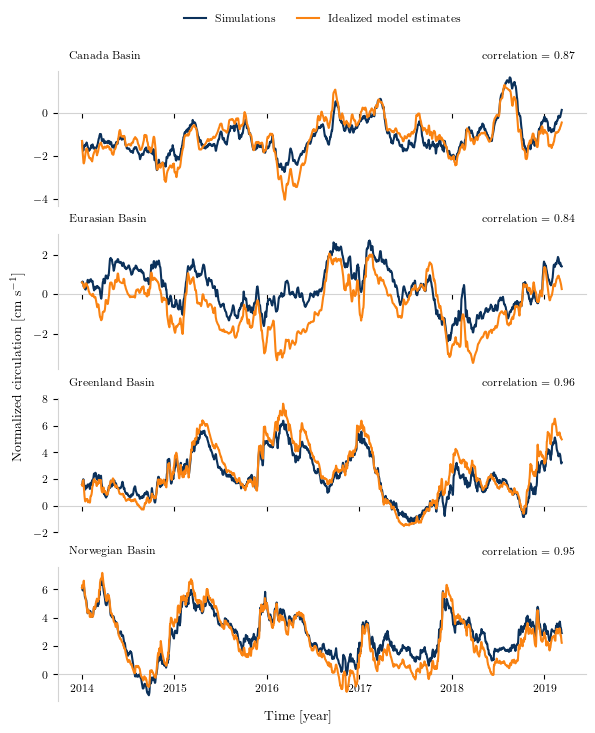

In [17]:
if savefigs:
    fig_ts_est.savefig(figpath+"timeseries_analytical.pdf")
fig_ts_est

## Filter sensitivity
We plot the correlation as a function of filter scale to see how sensitive the results are to the degree of filtering. 

### Code

In [18]:
%%capture

# Set the width of the figure layout
width = 'one_column'

# Define the depth level for the analysis
depth = 2750

# File path to linear model estimates
est_filepath = datapath + 'estimates/'

# Define the filter scales to be used in the analysis (in meters)
filter_scales = np.arange(0, 201, 20) * 1000

# List of basins to be analyzed
basins = np.array(["canadian", "eurasian", "greenland", "norwegian"])

# Initialize an array to store correlation values for each basin and filter scale
rs = np.zeros((len(filter_scales), len(basins)))

# Loop through each filter scale and basin to extract the maximum correlation values
for i, filter_scale in enumerate(filter_scales):
    for j, basin in enumerate(basins):
        # Construct the file path for the current basin and filter scale
        cfile = est_filepath + f"{basin}_{depth}_{filter_scale}_estimates.nc"
        
        # Open the dataset from the NetCDF file
        est = xr.open_dataset(cfile)
        
        # Extract the maximum correlation value
        r = est.r.max().values
        
        # Store the correlation value in the array
        rs[i, j] = r

# Create an xarray Dataset to hold the correlation values
ds = xr.Dataset(
    data_vars=dict(
        correlation=(["filter_scale", "basin"], rs),
    ),
    coords=dict(
        filter_scale=filter_scales,
        basin=basins,
    ),
)    

# Use a colorblind-friendly style for the plot
plt.style.use('tableau-colorblind10')
color_cycle = plt.rcParams['axes.prop_cycle']
colors = [color['color'] for color in color_cycle]

# Determine the size of the figure
sizex, sizey = set_size(width, subplots=(1, 1))

# Create a figure and axis for the plot
fig_filter, ax = plt.subplots(constrained_layout=True, figsize=(sizex, sizey))

# Customize the appearance of the axes
ax.spines['right'].set_color('none')  # Remove the right spine
ax.yaxis.tick_left()  # Keep the left ticks
ax.spines['top'].set_color('none')  # Remove the top spine
ax.xaxis.tick_bottom()  # Keep the bottom ticks

# Set the color of the remaining spines to light gray
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

# Add grid lines to the y-axis for better readability
ax.grid(axis="y", which='both', 
        color='lightgrey', 
        linestyle='-', 
        linewidth=0.5, 
        alpha=0.5)

# Ensure that grid lines are drawn below other plot elements
ax.set_axisbelow(True)

# Loop through each basin to plot the correlation data
for i, basin in enumerate(["canadian", "eurasian", "greenland", "norwegian"]):
    
    # Select the data corresponding to the current basin
    dss = ds.sel(basin=basin)
    
    # Plot the correlation data as a scatter plot
    ax.scatter(dss.filter_scale / 1e3, dss.correlation, 
               label=titles[basin].split()[0],  # Use the first word of the basin title as the label
               color=colors[i],
               marker="."
               )
    
# Add a legend to the plot
ax.legend(ncol=2, 
          loc='lower left')

# Set the labels for the x and y axes
ax.set_ylabel("Correlation")
ax.set_xlabel("Filter cutoff [km]")

# Set the y-axis limits to focus on the relevant correlation range
ax.set_ylim(0.7, 1)


### Figure

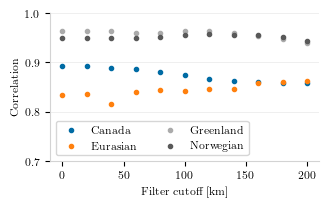

In [19]:
if savefigs:
    fig_filter.savefig(figpath+"filter_sensitivity.pdf")
fig_filter

## Correlation and friction coefficient as function of depth
We plot the correlation and optimal friction coeficient $R$ as a function of depth $H$ for the different basins.

### Code

In [20]:
%%capture

# Set the width of the figure layout
width = 'one_column'

# Use a colorblind-friendly style for the plot
plt.style.use('tableau-colorblind10')
color_cycle = plt.rcParams['axes.prop_cycle']
colors = [color['color'] for color in color_cycle]

# Determine the size of the figure based on the layout width and adjust the height
sizex, sizey = set_size(width, subplots=(1, 1))
sizey *= 1.5

# Create Figure
fig_r_R = plt.figure(constrained_layout=True, figsize=(sizex, sizey))
axd = fig_r_R.subplot_mosaic(
    [
        ['r'],
        ['R'],
    ],
)

# Customize the appearance of the axes in both subplots
for ax in axd.values():
    # Remove the right spine and corresponding ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # Remove the top spine and corresponding ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()

    # Set the color of the left and bottom spines to light gray
    ax.spines['left'].set_color('lightgray')
    ax.spines['bottom'].set_color('lightgray')

# Define the basins and depths to be analyzed
basins = np.array(["canadian", "eurasian", "greenland", "norwegian"])
depths = np.array([2500, 2750, 3000, 3250, 3500, 3750])

# Define the horizontal offset for plotting and the marker size
xinc = 30
markersize = 4

# Define the filter scale to be used
filter_scale = 100000

# Loop through each basin to calculate and plot the correlation and friction coefficient R
for i, basin in enumerate(basins):
    Rs = []
    rs = []
    
    # Loop through each depth to extract the maximum correlation and corresponding R values
    for depth in depths:
        cfile = est_filepath + f"{basin}_{depth}_{filter_scale}_estimates.nc"
        
        if os.path.exists(cfile):
            data = xr.open_dataset(cfile)
            
            # Extract the maximum correlation value
            corr = data.r.max().values
            
            # Extract the R value corresponding to the maximum correlation
            R = data.r.idxmax().values
            
        else:
            # Handle missing files by assigning NaN
            corr = np.nan 
            R = np.nan
        
        # Store the extracted values in the respective lists
        Rs.append(R)
        rs.append(corr)
    
    # Adjust the x-axis positions for plotting
    x = (i - 2) * xinc + depths
    
    # Plot the correlation values in the 'r' subplot
    axd['r'].scatter(x, rs,
                     label=titles[basin].split()[0],  # Use the first word of the basin title as the label
                     color=colors[i],
                     marker="."
                     )
    
    # Plot the R values in the 'R' subplot
    axd['R'].scatter(x, Rs, 
                     label=titles[basin].split()[0], 
                     color=colors[i],
                     marker="."
                     )

# Customize the 'r' subplot
axd['r'].set_ylim(0.4, 1)  # Set the y-axis limits for correlation values
axd['r'].legend(loc='lower left', ncol=2)  # Add a legend with 2 columns
axd['r'].set_ylabel('Correlation')  # Set the y-axis label
axd['r'].set_xticks(depths)  # Set the x-ticks to the depth values
axd['r'].set_xticklabels([])  # Remove x-tick labels

# Customize the 'R' subplot
axd['R'].set_yscale('log')  # Use a logarithmic scale for the y-axis (R values)
axd['R'].set_ylabel('Friction coefficient $R$ [ms$^{-1}$]')  # Set the y-axis label
axd['R'].set_ylim(None, 0.003)  # Set the upper limit for the y-axis
axd['R'].set_xticks(depths)  # Set the x-ticks to the depth values
axd['R'].set_xlabel('Contour depth $H$ [m]')  # Set the x-axis label

# Add grid lines to both subplots for better readability
for key, ax in axd.items():
    ax.grid(axis="y", which='both', 
            color='lightgrey', 
            linestyle='-', 
            linewidth=0.5, 
            alpha=0.5)
    ax.set_axisbelow(True)  # Ensure grid lines are drawn below plot elements


### Figure

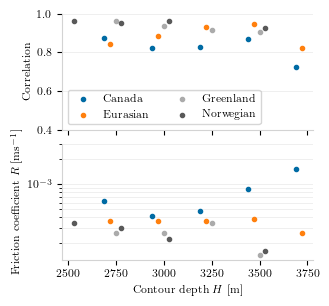

In [21]:
if savefigs:
    fig_r_R.savefig(figpath+"correlation_R.pdf")
fig_r_R

## 2D histogram of analytical estimates vs ROMS-A4

### Code

In [22]:
%%capture

# Set the width of the figure layout
width = 'one_column'

# number of time steps
nt = 1895

# Define the basins and depths to be analyzed
basins = np.array(["canadian", "eurasian", "greenland", "norwegian"])
depths = np.array([2500, 2750, 3000, 3250, 3500, 3750])

# Initialize arrays to store circulation estimates and bottom circulation for each basin and depth
circulation_estimated = np.zeros((len(basins), len(depths), nt))
circulation_bottom = np.zeros((len(basins), len(depths), nt))

# Create an array of NaNs to handle missing data
tsnan = np.zeros(nt) * np.nan

# Loop through each basin and depth to extract circulation data
for i, basin in enumerate(basins):
    for j, depth in enumerate(depths):
        cfile = est_filepath + f"{basin}_{depth}_{filter_scale}_estimates.nc"
        
        if os.path.exists(cfile):
            data = xr.open_dataset(cfile)
            
            # Select the R value corresponding to the maximum correlation
            R = data.r.idxmax()
            ds = data.sel(R=R)
            
            # Store the estimated and bottom circulation values
            circulation_estimated[i, j, :] = ds.estimates.values
            circulation_bottom[i, j, :] = ds.circ_ub.values
        else:
            # Handle missing data by assigning NaN values
            circulation_estimated[i, j, :] = tsnan
            circulation_bottom[i, j, :] = tsnan

# Create a histogram plot to compare the distribution of estimated vs. simulated circulation
fig_hist_est, ax = plt.subplots(constrained_layout=True, figsize=(set_size(width)[0], set_size(width)[0]))

# Flatten the arrays and convert to the appropriate units (cm/s)
x = circulation_estimated.flatten() * 1e2
y = circulation_bottom.flatten() * 1e2

# Remove NaN values from the flattened arrays
x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

# Plot the joint histogram of estimated and simulated circulation values
sns.histplot(x=x, y=y, 
             bins=75, 
             pthresh=.1, 
             cmap="magma_r", 
             ax=ax,
             )

# Overlay KDE plot with white contours
sns.kdeplot(x=x, y=y, 
            levels=7, 
            color="w", 
            linewidths=1, 
            ax=ax
            )

# Plot a reference line (y=x) to help assess the agreement between estimates and simulations
ax.plot((-4, 8), (-4, 8), color='black', lw=0.5)

# Customize the appearance of the axes
ax.spines['right'].set_color('none')  # Remove the right spine
ax.yaxis.tick_left()  # Keep the left ticks

# Set the position of the bottom and left spines to zero
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

# Remove the top spine and corresponding ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()  # Keep the bottom ticks

# Set the color of the left and bottom spines to light gray
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

# Define the tick positions for the x and y axes
ax.set_yticks([-4, -2, 2, 4, 6, 8])
ax.set_xticks([-4, -2, 2, 4, 6, 8])

# Add labels to the figure
fig_hist_est.supxlabel('Idealized model estimates [cm/s]')
fig_hist_est.supylabel('Simulated circulation [cm/s]')


### Figure

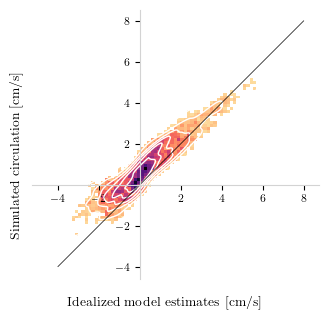

In [23]:
if savefigs:
    fig_hist_est.savefig(figpath+"scatter.pdf")
fig_hist_est